In [1]:
import os
from pathlib import Path

testfolder = 'TEMP' 
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in TEMP


In [2]:
from bifacial_radiance import *
import numpy as np
import pandas as pd
import datetime

In [46]:
# This information helps with debugging and getting support :)
import sys, platform
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

Working on a  Windows 10
Python version  3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.0
bifacial_radiance version  0.4.2+162.g124b2da.dirty


In [3]:
startdt = datetime.datetime(2001,3,15,0)
enddt = datetime.datetime(2001,6,30,23)

In [4]:
lat = 44.57615187732146   
lon = -123.23914850912513
clearance_heights = [0.88, 0.9482582, 0.6985] # m
ygaps = [0.02, 0.02, 0.02] # m
cws = [3.3655, 3.3655, 3.9624] # m
rtrs = [6.223, 8.4201, 6.8453] # m
tilt = 25
sazm = 180
albedo = 0.2 # 'grass'

# Field size. Just going for 'steady state'
nMods = 20
nRows = 7

In [5]:
startdts = [datetime.datetime(2001,4,1,0),
            datetime.datetime(2001,5,1,0),
            datetime.datetime(2001,6,1,0),
            datetime.datetime(2001,7,1,0),
            datetime.datetime(2001,8,1,0),
            datetime.datetime(2001,9,1,0),
            datetime.datetime(2001,4,1,0),
            datetime.datetime(2001,10,1,0),]

enddts = [datetime.datetime(2001,5,1,0),
          datetime.datetime(2001,6,1,0),
          datetime.datetime(2001,7,1,0),
          datetime.datetime(2001,8,1,0),
          datetime.datetime(2001,9,1,0),
          datetime.datetime(2001,10,1,0),
          datetime.datetime(2001,10,1,0),
          datetime.datetime(2001,10,15,0),]


In [6]:
demo = RadianceObj('oregon', path=testfolder)
demo.setGround(albedo)
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057

path = TEMP
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_OR_Corvallis.Muni.AP.726945_TMY3.epw
 ... OK!


<div class="alert alert-block alert-warning"> Note that the following loop is saving the seasonal simulation as "Month 10", and what is half of October as "Month 11", as it is just following the loop index for startdates </div>

In [ ]:
simulate = True

if simulate:
    for setup in range(0, 3):
        for mmonth in range(len(startdts)-1, len(startdts)):
            y = (cws[setup]-ygaps[setup])/2
            module = demo.makeModule(name='module_site'+str(setup+1), x=1, y=y, numpanels=2, 
                                    ygap=ygaps[setup])
            startdt = startdts[mmonth]
            enddt = enddts[mmonth]
            metdata = demo.readWeatherFile(epwfile, starttime=startdt, endtime=enddt, coerce_year=2001) # read in the EPW weather data from above
            demo.genCumSky(savefile=str(mmonth))
            #demo.gendaylit(4020)  # Use this to simulate only one hour at a time. 

            sceneDict = {'tilt':tilt, 'pitch':rtrs[setup], 'clearance_height':clearance_heights[setup], 
                         'azimuth':sazm, 'nMods':nMods, 'nRows':nRows}  
            scene = demo.makeScene(module=module, sceneDict=sceneDict) 
            octfile = demo.makeOct(demo.getfilelist())  

            analysis = AnalysisObj(octfile, demo.name)
            spacingbetweensamples = 0.05 # m
            sensorsy = int(np.floor(rtrs[setup]/spacingbetweensamples)+1)
            sensorsx = 1

            # Module first
            frontscan, backscan = analysis.moduleAnalysis(scene, sensorsx = 1, sensorsy=10)
            analysis.analysis(octfile, 'MODULE_Month_'+str(mmonth+4)+'_setup_'+(str(setup+1)), frontscan, backscan)  # compare the back vs front irradiance  

            groundscan, backscan = analysis.moduleAnalysis(scene, sensorsx = 1, sensorsy=[sensorsy, 1])
            groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
            groundscan['zinc'] = 0   # no tilt necessary. 
            groundscan['yinc'] = spacingbetweensamples
            groundscan['ystart'] = 0

            analysis.analysis(octfile, 'GROUND_Month_'+str(mmonth+4)+'_setup_'+(str(setup+1)), groundscan, backscan)  # compare the back vs front irradiance  
        
        filesall = os.listdir('results')

    # Cleanup of Ground 'back' files
    filestoclean = [e for e in filesall if e.endswith('_Back.csv')]
    for cc in range(0, len(filestoclean)):
        filetoclean = filestoclean[cc]
        os.remove(os.path.join('results', filetoclean))

In [7]:
GHIs = []
for mmonth in range(0, len(startdts)):
    startdt = startdts[mmonth]
    enddt = enddts[mmonth]
    metdata = demo.readWeatherFile(epwfile, starttime=startdt, endtime=enddt, coerce_year=2001)
    GHIs.append(metdata.dni.sum())

8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun posit

In [8]:
GHIs

[134786, 140103, 173864, 231673, 190246, 173658, 1044330, 48704]

## 2. Plot Bifacial Gain Results

In [9]:
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [10]:
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

#sns.set(rc={'figure.figsize':(5.7,4.27)})

In [11]:
testfolder

'TEMP'

In [12]:
import calendar

In [14]:
hub_heights = [4.3, 3.5, 2.5, 1.5]
results_BGG=[]
results_GFront=[]
results_GRear=[]
results_GGround=[]
results_coordY=[]
setups = []
months = []
results_GHI = []
for ii in range(0, len(clearance_heights)):
    for jj in range(0, len(startdts)):
        
        if jj == (len(startdts)-2):
            months.append('Season')
        elif jj == (len(startdts)-1): 
            months.append('October1-15')
        else:
            months.append(calendar.month_abbr[jj+4])
        setups.append(ii+1)
        # irr_GROUND_Month_6_setup_1_Row4_Module10_Back.csv
        fileground= os.path.join('results', f'irr_GROUND_Month_'+str(jj+4)+'_setup_'+str(ii+1)+'_Row4_Module10_Front.csv')
        filepv= os.path.join('results', f'irr_MODULE_Month_'+str(jj+4)+'_setup_'+str(ii+1)+'_Row4_Module10.csv')
        resultsGround = load.read1Result(fileground)
        resultsPV = load.read1Result(filepv)
        #  resultsDF = load.cleanResult(resultsDF).dropna() # I checked them they are good because even number of sensors
        results_GGround.append(list(resultsGround['Wm2Front']))
        results_coordY.append(list(resultsGround['y']))
        results_GFront.append(list(resultsPV['Wm2Front']))
        results_GRear.append(list(resultsPV['Wm2Back']))
        results_BGG.append(resultsPV['Wm2Back'].sum()*100/resultsPV['Wm2Front'].sum())
        results_GHI.append(GHIs[jj])


In [15]:
df = pd.DataFrame(list(zip(setups, months, results_GHI, results_coordY, results_GGround,
                          results_GFront, results_GRear, results_BGG)),
               columns =['Setup', 'Month', 'GHI', 'GroundCoordY', 'Gground', 'Gfront', 'Grear', 'BGG'])

In [16]:
# Example of selectiong one setup one month
df[(df['Setup']==1) & (df['Month']=='Apr')]

,Setup,Month,GHI,GroundCoordY,Gground,Gfront,Grear,BGG
0,1,Apr,134786,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[12917.340000000002, 13129.23, 13341.17, 13553...","[156531.2, 157880.0, 159227.9, 161578.3, 16227...","[13627.049999999996, 11563.37, 10237.97, 9411....",6.67198


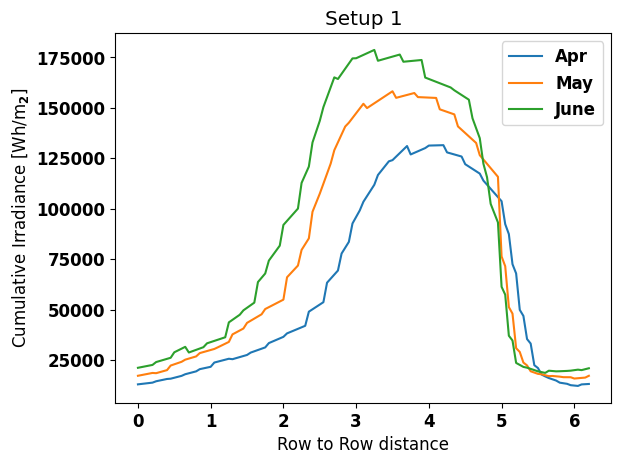

In [17]:
foo = df[(df['Setup']==1) & (df['Month']=='Apr')]
foo1 = df[(df['Setup']==1) & (df['Month']=='May')]
foo2 = df[(df['Setup']==1) & (df['Month']=='Jun')]

plt.plot(foo['GroundCoordY'][0], foo['Gground'].iloc[0], label='Apr')
plt.plot(foo['GroundCoordY'][0], foo1['Gground'].iloc[0], label='May')
plt.plot(foo['GroundCoordY'][0], foo2['Gground'].iloc[0], label='June')
plt.title('Setup 1')
plt.xlabel('Row to Row distance')
plt.ylabel('Cumulative Irradiance [Wh/m$_2$]')
plt.legend()

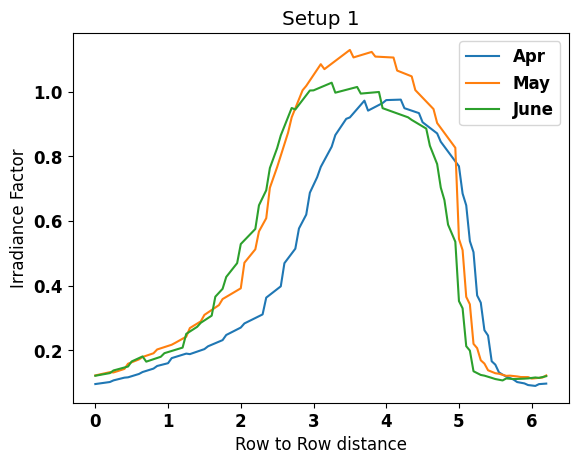

In [18]:
foo = df[(df['Setup']==1) & (df['Month']=='Apr')]
foo1 = df[(df['Setup']==1) & (df['Month']=='May')]
foo2 = df[(df['Setup']==1) & (df['Month']=='Jun')]

plt.plot(foo['GroundCoordY'][0], foo['Gground'].iloc[0]/foo['GHI'].iloc[0], label='Apr')
plt.plot(foo['GroundCoordY'][0], foo1['Gground'].iloc[0]/foo1['GHI'].iloc[0], label='May')
plt.plot(foo['GroundCoordY'][0], foo2['Gground'].iloc[0]/foo2['GHI'].iloc[0], label='June')
plt.title('Setup 1')
plt.xlabel('Row to Row distance')
plt.ylabel('Irradiance Factor')
plt.legend();

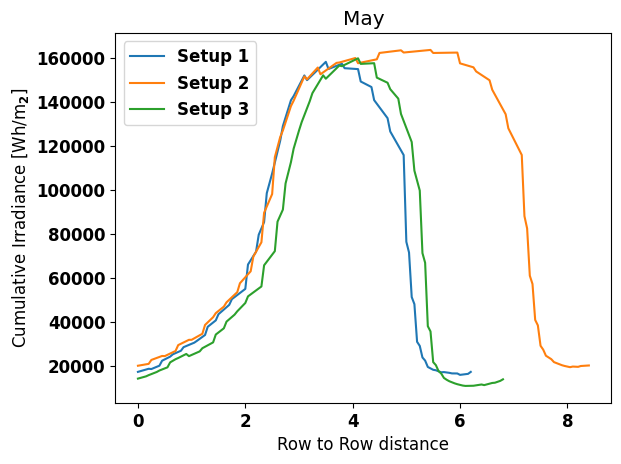

In [19]:
foo = df[(df['Setup']==1) & (df['Month']=='May')]
foo1 = df[(df['Setup']==2) & (df['Month']=='May')]
foo2 = df[(df['Setup']==3) & (df['Month']=='May')]

plt.plot(foo['GroundCoordY'].iloc[0], foo['Gground'].iloc[0], label='Setup 1')
plt.plot(foo1['GroundCoordY'].iloc[0], foo1['Gground'].iloc[0], label='Setup 2')
plt.plot(foo2['GroundCoordY'].iloc[0], foo2['Gground'].iloc[0], label='Setup 3')
plt.title('May')
plt.xlabel('Row to Row distance')
plt.ylabel('Cumulative Irradiance [Wh/m$_2$]')
plt.legend();

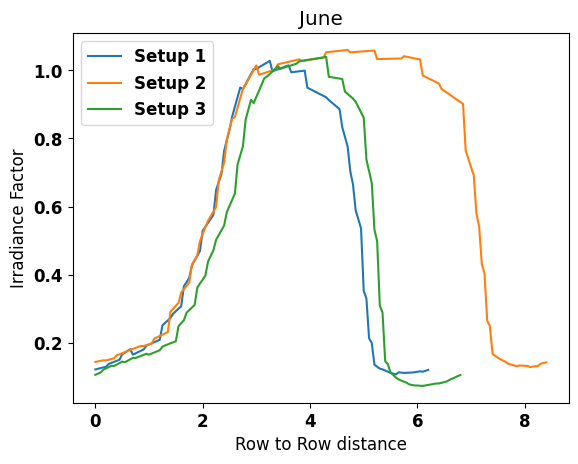

In [20]:
foo = df[(df['Setup']==1) & (df['Month']=='Jun')]
foo1 = df[(df['Setup']==2) & (df['Month']=='Jun')]
foo2 = df[(df['Setup']==3) & (df['Month']=='Jun')]

plt.plot(foo['GroundCoordY'].iloc[0], foo['Gground'].iloc[0]/foo['GHI'].iloc[0], label='Setup 1')
plt.plot(foo1['GroundCoordY'].iloc[0], foo1['Gground'].iloc[0]/foo1['GHI'].iloc[0], label='Setup 2')
plt.plot(foo2['GroundCoordY'].iloc[0], foo2['Gground'].iloc[0]/foo2['GHI'].iloc[0], label='Setup 3')
plt.title('June')
plt.xlabel('Row to Row distance')
plt.ylabel('Irradiance Factor')
plt.legend();

## 3. Testbed Calculations

In [21]:
xps = []
for cw in cws:
    xps.append(np.round(cw*np.cos(np.radians(tilt))/2,2))
xps

[1.53, 1.53, 1.8]

In [22]:
df['Month'].unique()

array(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Season', 'October1-15'],
      dtype=object)

In [23]:
# SETUP Table
# Setups, by month, all irradiance on ground between rows

foo0 = df[(df['Setup']==1) & (df['Month']=='Apr')]
foo1 = df[(df['Setup']==1) & (df['Month']=='May')]
foo2 = df[(df['Setup']==1) & (df['Month']=='Jun')]
foo3 = df[(df['Setup']==1) & (df['Month']=='Jul')]
foo4 = df[(df['Setup']==1) & (df['Month']=='Aug')]
foo5 = df[(df['Setup']==1) & (df['Month']=='Sep')]
foo6 = df[(df['Setup']==1) & (df['Month']=='Season')]
foo7 = df[(df['Setup']==1) & (df['Month']=='October1-15')]


setup1 = pd.DataFrame(list(zip(foo0['Gground'].iloc[0],
                      foo1['Gground'].iloc[0],
                      foo2['Gground'].iloc[0],
                      foo3['Gground'].iloc[0],
                      foo4['Gground'].iloc[0],
                      foo5['Gground'].iloc[0],
                      foo7['Gground'].iloc[0],
                      foo6['Gground'].iloc[0],
                     )), columns=['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'October1-15', 'Season'],
                     index=foo0['GroundCoordY'].iloc[0])

foo0 = df[(df['Setup']==2) & (df['Month']=='Apr')]
foo1 = df[(df['Setup']==2) & (df['Month']=='May')]
foo2 = df[(df['Setup']==2) & (df['Month']=='Jun')]
foo3 = df[(df['Setup']==2) & (df['Month']=='Jul')]
foo4 = df[(df['Setup']==2) & (df['Month']=='Aug')]
foo5 = df[(df['Setup']==2) & (df['Month']=='Sep')]
foo6 = df[(df['Setup']==2) & (df['Month']=='Season')]
foo7 = df[(df['Setup']==2) & (df['Month']=='October1-15')]


setup2 = pd.DataFrame(list(zip(foo0['Gground'].iloc[0],
                      foo1['Gground'].iloc[0],
                      foo2['Gground'].iloc[0],
                      foo3['Gground'].iloc[0],
                      foo4['Gground'].iloc[0],
                      foo5['Gground'].iloc[0],
                      foo7['Gground'].iloc[0],
                      foo6['Gground'].iloc[0],
                     )), columns=['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'October1-15', 'Season'],
                     index=foo0['GroundCoordY'].iloc[0])

foo0 = df[(df['Setup']==3) & (df['Month']=='Apr')]
foo1 = df[(df['Setup']==3) & (df['Month']=='May')]
foo2 = df[(df['Setup']==3) & (df['Month']=='Jun')]
foo3 = df[(df['Setup']==3) & (df['Month']=='Jul')]
foo4 = df[(df['Setup']==3) & (df['Month']=='Aug')]
foo5 = df[(df['Setup']==3) & (df['Month']=='Sep')]
foo6 = df[(df['Setup']==3) & (df['Month']=='Season')]
foo7 = df[(df['Setup']==3) & (df['Month']=='October1-15')]


setup3 = pd.DataFrame(list(zip(foo0['Gground'].iloc[0],
                      foo1['Gground'].iloc[0],
                      foo2['Gground'].iloc[0],
                      foo3['Gground'].iloc[0],
                      foo4['Gground'].iloc[0],
                      foo5['Gground'].iloc[0],
                      foo7['Gground'].iloc[0],
                      foo6['Gground'].iloc[0],
                     )), columns=['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'October1-15', 'Season'],
                     index=foo0['GroundCoordY'].iloc[0])


In [24]:
# Setup 1, by month, all irradiance on ground between rows
setup1

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
0.00,12917.34,17167.99,21124.36,17631.94,12600.42,9288.878,4214.145,91090.63
0.05,13129.23,17518.55,21479.33,17966.91,12838.43,9423.775,4185.341,92665.66
0.10,13341.17,17869.37,21834.13,18302.24,13076.51,9558.902,4156.536,94241.74
0.15,13553.10,18220.19,22188.92,18637.58,13314.59,9694.030,3783.320,95817.81
0.20,13765.04,18571.00,22543.72,20530.13,13201.47,8609.129,3844.603,96669.65
...,...,...,...,...,...,...,...,...
6.00,12317.70,15798.86,19951.30,17529.25,12001.39,10216.420,6656.832,90660.91
6.05,12135.57,15953.23,20201.37,17646.96,12315.27,10014.190,6402.485,90712.93
6.10,12885.72,16107.97,19972.51,17079.04,12374.39,9106.396,6148.140,90764.96
6.15,12994.88,16262.72,20432.69,17280.01,12433.42,9119.024,4963.138,91078.25


In [25]:
# edges is the irradiance undreneath the panels of the encompasing rows
# centers is where there is no panel
center1 = setup1[(setup1.index > xps[0]) & (setup1.index <= (setup1.index[-1] - xps[0]))]
edges1 = setup1[~(setup1.index > xps[0]) & (setup1.index <= (setup1.index[-1] - xps[0]))]
center2 = setup2[(setup2.index > xps[1]) & (setup2.index <= (setup2.index[-1] - xps[1]))]
edges2 = setup2[~(setup2.index > xps[1]) & (setup2.index <= (setup2.index[-1] - xps[1]))]
center3 = setup3[(setup3.index > xps[2]) & (setup3.index <= (setup3.index[-1] - xps[2]))]
edges3 = setup3[~(setup3.index > xps[2]) & (setup3.index <= (setup3.index[-1] - xps[2]))]

edges1

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
0.00,12917.34,17167.99,21124.36,17631.94,12600.42,9288.878,4214.145,91090.63
0.05,13129.23,17518.55,21479.33,17966.91,12838.43,9423.775,4185.341,92665.66
0.10,13341.17,17869.37,21834.13,18302.24,13076.51,9558.902,4156.536,94241.74
0.15,13553.10,18220.19,22188.92,18637.58,13314.59,9694.030,3783.320,95817.81
0.20,13765.04,18571.00,22543.72,20530.13,13201.47,8609.129,3844.603,96669.65
0.25,14445.29,18451.88,23967.80,21020.72,13523.14,8826.959,3905.886,99240.25
0.30,14824.56,18960.19,24498.64,21511.41,13844.90,9044.932,3967.169,101811.80
0.35,15203.79,19469.28,25029.67,22002.10,14166.67,9262.905,3680.838,104383.40
0.40,15583.03,19978.38,25560.70,22492.79,15428.00,9442.168,3763.199,108352.10
0.45,15722.21,22239.03,26091.73,24457.26,15860.90,9689.584,3845.561,111191.50


In [26]:
# Calculating the 3 testbeds. equidistant
dist1 = (center1.index[-1]-center1.index[0])/3
dist2 = (center2.index[-1]-center2.index[0])/3
dist3 = (center3.index[-1]-center3.index[0])/3

setup1testbedA = center1[center1.index <= (center1.index[0] + dist1)]
setup1testbedB = center1[(center1.index > (center1.index[0] + dist1)) & (center1.index <= (center1.index[0] + dist1*2))]
setup1testbedC = center1[center1.index > (center1.index[0] + dist1*2)]

setup2testbedA = center2[center2.index <= (center2.index[0] + dist2)]
setup2testbedB = center2[(center2.index > (center2.index[0] + dist2)) & (center2.index <= (center2.index[0] + dist2*2))]
setup2testbedC = center2[center2.index > (center2.index[0] + dist2*2)]

setup3testbedA = center3[center3.index <= (center3.index[0] + dist3)]
setup3testbedB = center3[(center3.index > (center3.index[0] + dist3)) & (center3.index <= (center3.index[0] + dist3*2))]
setup3testbedC = center3[center3.index > (center3.index[0] + dist3*2)]


In [27]:
IFtable = [np.round(list(setup1testbedA.mean()/GHIs),2),
np.round(list(setup1testbedB.mean()/GHIs),2),
np.round(list(setup1testbedC.mean()/GHIs),2),
np.round(list(setup2testbedA.mean()/GHIs),2),
np.round(list(setup2testbedB.mean()/GHIs),2),
np.round(list(setup2testbedC.mean()/GHIs),2),
np.round(list(setup3testbedA.mean()/GHIs),2),
np.round(list(setup3testbedB.mean()/GHIs),2),
np.round(list(setup3testbedC.mean()/GHIs),2),
np.round(list(edges1.mean()/GHIs),2),
np.round(list(edges2.mean()/GHIs),2),
np.round(list(edges3.mean()/GHIs),2),
GHIs]

IFresults = pd.DataFrame(IFtable, index = ['Setup 1 TB A', 'Setup 1 TB B', 'Setup 1 TB C',
                                             'Setup 2 TB A', 'Setup 2 TB B', 'Setup 2 TB C',
                                             'Setup 3 TB A', 'Setup 3 TB B', 'Setup 3 TB C',
                                          'Setup 1 Under Panel', 'Setup 2 Under Panel', 'Setup 3 Under Panel', 'GHIs [Wh/m2]'],
                        columns = setup1testbedB.columns)
IFresults

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
Setup 1 TB A,0.29,0.49,0.55,0.38,0.26,0.14,0.01,7.53
Setup 1 TB B,0.74,1.04,0.99,0.86,0.73,0.33,0.01,16.69
Setup 1 TB C,0.95,1.06,0.93,0.84,0.85,0.65,0.02,18.88
Setup 2 TB A,0.44,0.70,0.72,0.56,0.42,0.19,0.01,10.82
Setup 2 TB B,1.00,1.14,1.04,0.91,0.90,0.65,0.02,19.92
Setup 2 TB C,1.02,1.11,1.00,0.89,0.90,0.76,0.04,20.17
Setup 3 TB A,0.30,0.51,0.57,0.40,0.27,0.14,0.01,7.87
Setup 3 TB B,0.76,1.05,0.99,0.86,0.74,0.34,0.01,16.82
Setup 3 TB C,0.95,1.07,0.97,0.86,0.86,0.65,0.02,18.93
Setup 1 Under Panel,0.15,0.19,0.18,0.12,0.11,0.07,0.00,2.87


In [28]:
Meanstable = [np.round(list(setup1testbedA.mean()),2),
np.round(list(setup1testbedB.mean()),2),
np.round(list(setup1testbedC.mean()),2),
np.round(list(setup2testbedA.mean()),2),
np.round(list(setup2testbedB.mean()),2),
np.round(list(setup2testbedC.mean()),2),
np.round(list(setup3testbedA.mean()),2),
np.round(list(setup3testbedB.mean()),2),
np.round(list(setup3testbedC.mean()),2),
np.round(list(edges1.mean()),2),
np.round(list(edges2.mean()),2),
np.round(list(edges3.mean()),2),
GHIs]

Meansresults = pd.DataFrame(Meanstable, index = ['Setup 1 TB A [Wh/m2]', 'Setup 1 TB B [Wh/m2]', 'Setup 1 TB C [Wh/m2]',
                                             'Setup 2 TB A [Wh/m2]', 'Setup 2 TB B [Wh/m2]', 'Setup 2 TB C [Wh/m2]',
                                             'Setup 3 TB A [Wh/m2]', 'Setup 3 TB B [Wh/m2]', 'Setup 3 TB C [Wh/m2]',
                                          'Setup 1 Under Panel [Wh/m2]', 'Setup 2 Under Panel [Wh/m2]', 'Setup 3 Under Panel [Wh/m2]', 'GHIs [Wh/m2]'],
                        columns = setup1testbedB.columns)
Meansresults

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
Setup 1 TB A [Wh/m2],39102.08,68750.16,95712.88,88232.43,49673.55,23577.95,8065.50,366950.98
Setup 1 TB B [Wh/m2],99204.79,145636.84,171972.12,198589.50,138555.57,57955.57,11606.48,812771.56
Setup 1 TB C [Wh/m2],127391.02,148438.68,162213.64,193589.93,161132.33,112448.51,21847.42,919773.51
Setup 2 TB A [Wh/m2],58722.21,98432.28,125904.47,130462.30,79782.00,33142.20,9300.75,526745.07
Setup 2 TB B [Wh/m2],135225.22,159288.67,180854.52,209748.07,170349.30,113138.37,23325.89,970139.90
Setup 2 TB C [Wh/m2],137426.43,156093.28,173321.71,205482.51,170407.45,132479.61,37033.25,982585.79
Setup 3 TB A [Wh/m2],40976.37,70902.31,99857.69,92889.32,51913.83,23916.07,8034.22,383499.95
Setup 3 TB B [Wh/m2],101789.12,146737.32,172906.09,200292.70,140930.99,59890.78,11953.90,819333.39
Setup 3 TB C [Wh/m2],128050.88,149517.87,168562.36,199186.46,163279.99,112178.00,21561.13,922056.43
Setup 1 Under Panel [Wh/m2],19569.14,27106.78,32135.80,28546.71,20046.32,11831.33,4592.17,139557.58


In [29]:
# Describe dataframes for each testbed/setup
A1 = np.round(setup1testbedA.describe(),2)
B1 = np.round(setup1testbedB.describe(),2)
C1 = np.round(setup1testbedC.describe(),2)
A2 = np.round(setup2testbedA.describe(),2)
B2 = np.round(setup2testbedB.describe(),2)
C2 = np.round(setup2testbedC.describe(),2)
A3 = np.round(setup3testbedA.describe(),2)
B3 = np.round(setup3testbedB.describe(),2)
C3 = np.round(setup3testbedC.describe(),2)
E1 = np.round(edges1.describe())
E2 = np.round(edges2.describe())
E3 = np.round(edges3.describe())


In [44]:
with pd.ExcelWriter("Results_16Nov23.xlsx") as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    IFresults.to_excel(writer, sheet_name="Irradiance Factors", index=True)
    Meansresults.to_excel(writer, sheet_name="Mean Irradiances", index=True)
    A1.to_excel(writer, sheet_name="Setup 1 TB C", index=True)
    B1.to_excel(writer, sheet_name="Setup 1 TB B", index=True)
    C1.to_excel(writer, sheet_name="Setup 1 TB C", index=True)    
    E1.to_excel(writer, sheet_name="Setup 1 UnderPanel", index=True)
    A2.to_excel(writer, sheet_name="Setup 2 TB C", index=True)
    B2.to_excel(writer, sheet_name="Setup 2 TB C", index=True)
    C2.to_excel(writer, sheet_name="Setup 2 TB C", index=True)
    E2.to_excel(writer, sheet_name="Setup 2 UnderPanel", index=True)
    A3.to_excel(writer, sheet_name="Setup 3 TB C", index=True)
    B3.to_excel(writer, sheet_name="Setup 3 TB C", index=True)
    C3.to_excel(writer, sheet_name="Setup 3 TB C", index=True)
    E3.to_excel(writer, sheet_name="Setup 1 UnderPanel", index=True)


In [31]:
# EXPANDED Describe dataframes for each testbed/setup

In [32]:
np.round(setup1testbedA.describe(),2)

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,21.00,21.00,21.00,21.00,21.00,21.00,21.00,21.00
mean,39102.08,68750.16,95712.88,88232.43,49673.55,23577.95,8065.50,366950.98
std,8030.03,22022.05,29614.19,37294.91,14900.20,4577.52,957.93,114896.13
min,28659.94,44454.22,52151.80,45530.74,32552.17,17527.45,6034.23,224246.40
25%,33367.99,51183.16,74255.18,60755.10,37902.07,20434.98,7373.00,278247.10
50%,38182.91,65998.93,93964.67,76535.12,46618.28,23174.20,8037.56,336766.70
75%,41941.55,82418.94,116825.10,97219.78,57593.42,25355.09,8781.63,398157.00
max,53648.24,112387.60,150350.10,161956.20,80868.81,31531.98,9698.28,609292.80


In [33]:
np.round(setup1testbedB.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
mean,99205.0,145637.0,171972.0,198590.0,138556.0,57956.0,11606.0,812772.0
std,21991.0,11746.0,6215.0,10332.0,27868.0,19543.0,1069.0,86302.0
min,63302.0,117360.0,155266.0,169795.0,84063.0,33560.0,9827.0,633262.0
25%,80652.0,140729.0,169396.0,197257.0,121098.0,43033.0,10877.0,750097.0
50%,103432.0,149870.0,174504.0,202586.0,144507.0,58725.0,11773.0,836912.0
75%,118955.0,154631.0,175893.0,205250.0,163057.0,73452.0,12403.0,881079.0
max,127559.0,158200.0,178701.0,207913.0,171570.0,90177.0,13649.0,916272.0


In [34]:
np.round(setup1testbedC.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
mean,127391.0,148439.0,162214.0,193590.0,161132.0,112449.0,21847.0,919774.0
std,4002.0,8417.0,9333.0,8538.0,7161.0,8171.0,5063.0,23678.0
min,118558.0,132580.0,139886.0,174287.0,146852.0,95289.0,13794.0,863902.0
25%,126366.0,140783.0,157527.0,187915.0,153617.0,108210.0,18669.0,914797.0
50%,127905.0,149252.0,162191.0,195650.0,165684.0,115802.0,21992.0,924715.0
75%,131054.0,155230.0,172839.0,197589.0,165952.0,119487.0,25897.0,936742.0
max,131480.0,157336.0,173707.0,206662.0,166241.0,120402.0,28894.0,946499.0


In [35]:
np.round(setup2testbedA.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
mean,58722.0,98432.0,125904.0,130462.0,79782.0,33142.0,9301.0,526745.0
std,26631.0,39931.0,42503.0,59599.0,41897.0,13700.0,1760.0,222208.0
min,28870.0,45861.0,55145.0,49558.0,33073.0,18186.0,6557.0,225799.0
25%,36594.0,59863.0,89388.0,71436.0,42047.0,22324.0,7884.0,314877.0
50%,50997.0,93797.0,132687.0,136428.0,66728.0,29645.0,9222.0,476292.0
75%,72780.0,138680.0,169714.0,192541.0,115683.0,41292.0,10820.0,742037.0
max,114225.0,154278.0,176387.0,205467.0,156436.0,64527.0,12680.0,879150.0


In [36]:
np.round(setup2testbedB.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
mean,135225.0,159289.0,180855.0,209748.0,170349.0,113138.0,23326.0,970140.0
std,6253.0,3043.0,2702.0,2124.0,4076.0,19947.0,7958.0,36497.0
min,117003.0,152544.0,174263.0,206362.0,158435.0,66329.0,12815.0,888101.0
25%,133249.0,157789.0,178846.0,208454.0,169167.0,99808.0,14512.0,948256.0
50%,136883.0,158915.0,180136.0,209294.0,170710.0,121220.0,23701.0,980810.0
75%,139834.0,162496.0,183404.0,210589.0,172582.0,129832.0,30803.0,999072.0
max,141610.0,163449.0,184267.0,213686.0,176889.0,133282.0,35601.0,1020022.0


In [37]:
np.round(setup2testbedC.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
mean,137426.0,156093.0,173322.0,205483.0,170407.0,132480.0,37033.0,982586.0
std,5698.0,8571.0,8848.0,9085.0,5819.0,2719.0,916.0,43010.0
min,123881.0,134371.0,156715.0,177475.0,153164.0,126617.0,34848.0,874489.0
25%,133213.0,152037.0,166429.0,202664.0,168050.0,130114.0,36324.0,955753.0
50%,140436.0,159879.0,179620.0,209343.0,173395.0,132838.0,37322.0,1000002.0
75%,141270.0,162405.0,179859.0,209929.0,174364.0,135032.0,37760.0,1013518.0
max,142357.0,163626.0,183960.0,214022.0,174894.0,135735.0,38065.0,1025148.0


In [38]:
np.round(setup3testbedA.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
mean,40976.0,70902.0,99858.0,92889.0,51914.0,23916.0,8034.0,383500.0
std,9575.0,23407.0,30986.0,37412.0,16316.0,5227.0,1006.0,127370.0
min,28908.0,44713.0,54089.0,50302.0,32392.0,16998.0,6401.0,227243.0
25%,33674.0,52635.0,76947.0,59314.0,38213.0,20407.0,7189.0,278358.0
50%,38072.0,66449.0,93444.0,82074.0,48443.0,22886.0,8147.0,334533.0
75%,48343.0,87551.0,122091.0,117229.0,64562.0,28749.0,8683.0,480434.0
max,58991.0,118666.0,158794.0,162517.0,83180.0,33544.0,9951.0,622246.0


In [39]:
np.round(setup3testbedB.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
mean,101789.0,146737.0,172906.0,200293.0,140931.0,59891.0,11954.0,819333.0
std,22331.0,10729.0,6209.0,11281.0,25180.0,18920.0,1249.0,93268.0
min,65167.0,122801.0,157138.0,168416.0,94519.0,34236.0,10088.0,640462.0
25%,85214.0,140274.0,170682.0,196805.0,119838.0,43750.0,10865.0,761703.0
50%,103730.0,150528.0,175053.0,203132.0,152107.0,54281.0,11957.0,839431.0
75%,122062.0,155304.0,176840.0,209118.0,161761.0,70633.0,12932.0,895776.0
max,131382.0,158022.0,179134.0,211035.0,168274.0,94423.0,14004.0,936276.0


In [40]:
np.round(setup3testbedC.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
mean,128051.0,149518.0,168562.0,199186.0,163280.0,112178.0,21561.0,922056.0
std,4518.0,9558.0,10180.0,9538.0,6075.0,7264.0,4757.0,42267.0
min,118285.0,128114.0,149664.0,175930.0,143275.0,96804.0,14144.0,812350.0
25%,124492.0,144332.0,160626.0,196761.0,162161.0,106991.0,19603.0,905864.0
50%,129565.0,150442.0,169866.0,202426.0,164153.0,115478.0,22180.0,946893.0
75%,131389.0,157460.0,179578.0,202632.0,165092.0,118266.0,25626.0,952524.0
max,133051.0,159806.0,180688.0,212186.0,172172.0,119066.0,27433.0,962819.0


In [41]:
np.round(edges1.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
mean,19569.0,27107.0,32136.0,28547.0,20046.0,11831.0,4592.0,139558.0
std,4841.0,7644.0,8686.0,7767.0,5961.0,2455.0,714.0,36969.0
min,12917.0,17168.0,21124.0,17632.0,12600.0,8609.0,3681.0,91091.0
25%,15393.0,19724.0,25295.0,22247.0,14797.0,9624.0,3989.0,106368.0
50%,18881.0,26227.0,30613.0,27306.0,19105.0,11503.0,4306.0,139395.0
75%,24429.0,31741.0,35356.0,33519.0,24606.0,13739.0,5164.0,161259.0
max,27484.0,43393.0,50876.0,44376.0,31796.0,17202.0,5939.0,218477.0


In [42]:
np.round(edges2.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
mean,21244.0,29520.0,33467.0,30320.0,21784.0,13683.0,5715.0,151214.0
std,3937.0,7473.0,7696.0,7462.0,5417.0,1975.0,457.0,33018.0
min,16357.0,19959.0,24996.0,20055.0,15617.0,11419.0,5100.0,111695.0
25%,17503.0,23723.0,27596.0,23465.0,16878.0,12094.0,5446.0,123321.0
50%,20569.0,29350.0,32161.0,30038.0,20680.0,12849.0,5588.0,140538.0
75%,24567.0,33471.0,37247.0,34461.0,26157.0,15195.0,5985.0,173793.0
max,28292.0,44876.0,53635.0,45322.0,32222.0,17874.0,6769.0,220700.0


In [43]:
np.round(edges3.describe())

,Apr,May,Jun,Jul,Aug,Sep,October1-15,Season
count,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0
mean,18538.0,25518.0,30484.0,26829.0,18886.0,11437.0,4173.0,131231.0
std,5301.0,8458.0,9133.0,8719.0,6434.0,2812.0,1109.0,39203.0
min,10605.0,14100.0,18383.0,14527.0,9851.0,7283.0,2550.0,76182.0
25%,13853.0,18265.0,24410.0,21352.0,13376.0,8932.0,3154.0,100929.0
50%,18270.0,24700.0,28591.0,25389.0,18171.0,11193.0,4104.0,131278.0
75%,23367.0,29911.0,33926.0,30521.0,23382.0,14102.0,5077.0,157317.0
max,28352.0,43194.0,52761.0,48879.0,31768.0,16687.0,6283.0,221080.0
